In [1]:
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import os
import torch
from PIL import Image
import numpy as np
from tqdm import tqdm
from torch import nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleANN(nn.Module):
    def __init__(self):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(3 * 500 * 500, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        logits = self.fc3(x)
        x = self.sigmoid(logits)
        return logits, x

def check_image_colors(data):
    def get_rgb_values(tensor):
        # Find non-zero indices in the selected channel data
        nonzero_indices = torch.nonzero(tensor, as_tuple=True)
        # Extract non-zero values and convert to a set to remove duplicates
        nonzero_values = tensor[nonzero_indices]
        unique_nonzero_values = nonzero_values
        return unique_nonzero_values
    print("Shape:", data.shape)
    print("Red channel unique values:", get_rgb_values(data[:, :, 0]))
    print("Green channel unique values:", get_rgb_values(data[:, :, 1]))
    print("Blue channel unique values:", get_rgb_values(data[:, :, 2]))

def process_image(image_path):
    # Load image
    img = Image.open(image_path).convert('RGB')

    # Desired size
    target_width, target_height = 500, 500

    # Resize image preserving aspect ratio
    img.thumbnail((target_width, target_height))

    # Create a new image with black background
    new_img = Image.new('RGB', (target_width, target_height))
    width, height = img.size

    # Calculate positioning for centering the image
    left = (target_width - width) // 2
    top = (target_height - height) // 2
    new_img.paste(img, (left, top))

    return new_img, new_img

def images_to_tensor(directory, a, b, return_images=False):
    tensor_list = []
    image_list = []  # To store PIL images for visualization
    file_list = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))][a:b]
    for filename in tqdm(file_list, desc="Processing images", unit="images"):
        file_path = os.path.join(directory, filename)
        try:
            processed_img, original_img = process_image(file_path)
            img_tensor = torch.from_numpy(np.array(processed_img))
            # check_image_colors(img_tensor)
            img_tensor = img_tensor.permute(2, 0, 1).to(torch.float32) / 255 # CxHxW
            tensor_list.append(img_tensor)
            if return_images:
                image_list.append(original_img)  # Append original image
        except Exception as e:
            print(f"Error processing {filename}: {e}")

    tensors = torch.stack(tensor_list)
    return (tensors, image_list) if return_images else tensors

/home/jesse/miniconda3/envs/learn-pth/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing images: 100%|██████████| 2/2 [00:00<00:00, 60.08images/s]


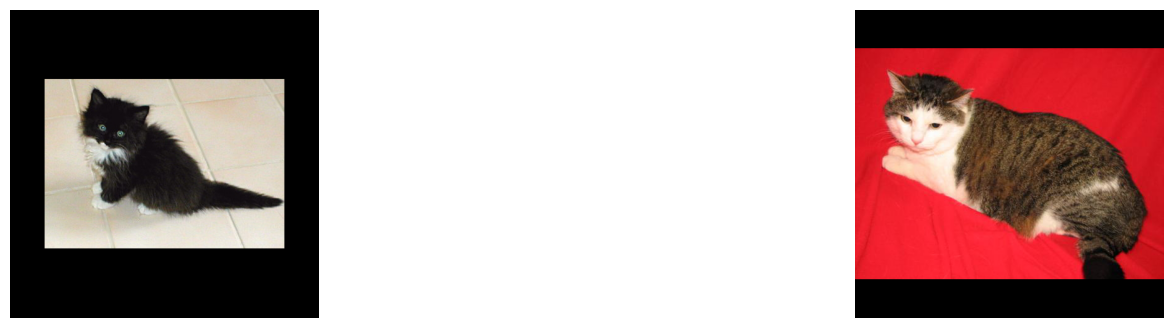

In [2]:
import matplotlib.pyplot as plt

start, finish = 99, 101
# Load the images and return both tensors and original images for display
data, original_images = images_to_tensor('PetImages/Cat', start, finish, return_images=True)

# Display the images using matplotlib
fig, axes = plt.subplots(1, finish-start, figsize=(20, 4))  # Adjust subplot parameters as needed
for i, img in enumerate(original_images):
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes
plt.show()

In [3]:
def get_rgb_values(tensor, rgb):
    # Selects the entire channel of the first image
    selected_channel_data = tensor[1, rgb, :, :]
    # Find non-zero indices in the selected channel data
    nonzero_indices = torch.nonzero(selected_channel_data, as_tuple=True)
    # Extract non-zero values and convert to a set to remove duplicates
    nonzero_values = selected_channel_data[nonzero_indices]
    unique_nonzero_values = nonzero_values # Convert to numpy array, then to list and set
    return unique_nonzero_values

# Usage of the function to get unique non-zero values for each color channel
red_rgb_values = get_rgb_values(data, 0)
green_rgb_values = get_rgb_values(data, 1)
blue_rgb_values = get_rgb_values(data, 2)

# Optionally print the minimum non-zero value to check
print("Minimum non-zero value for the Red channel:", sum(red_rgb_values)/len(red_rgb_values))
print("Minimum non-zero value for the Green channel:", sum(green_rgb_values)/len(green_rgb_values))
print("Minimum non-zero value for the Blue channel:", sum(blue_rgb_values)/len(blue_rgb_values))

Minimum non-zero value for the Red channel: tensor(0.7167)
Minimum non-zero value for the Green channel: tensor(0.2134)
Minimum non-zero value for the Blue channel: tensor(0.2105)


In [4]:
# Specify the directory containing the images
cats = 'PetImages/Cat'
dogs = 'PetImages/Dog'

# Convert images to a tensor
cats_tensor = images_to_tensor(cats, 0, 500)
dogs_tensor = images_to_tensor(dogs, 0, 500)
print(cats_tensor.shape)  # This should print: torch.Size([N, 3, 500, 500]), N is the number of processed images
print(dogs_tensor.shape)  # This should print: torch.Size([N, 3, 500, 500]), N is the number of processed images

# Labels (0 for cats, 1 for dogs)
cats_labels = torch.zeros(cats_tensor.size(0))
dogs_labels = torch.ones(dogs_tensor.size(0))

# Combine datasets
features = torch.cat([cats_tensor, dogs_tensor], dim=0)
labels = torch.cat([cats_labels, dogs_labels], dim=0)

# Create a dataset and data loader
dataset = TensorDataset(features, labels) # the first dimension is the data index
#delete cats and dogs tensor here
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)
del cats_tensor
del dogs_tensor
del features
del labels
# Initialize the neural network
model = SimpleANN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Processing images: 100%|██████████| 500/500 [00:12<00:00, 39.22images/s]


torch.Size([500, 3, 500, 500])
torch.Size([500, 3, 500, 500])


In [5]:
# Training loop
epochs = 10
for epoch in range(epochs):
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        _, outputs = model(inputs.view(inputs.shape[0], -1))  # Flatten the inputs
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    if loss.item() < 35:
        break

# Save the model if needed
torch.save(model.state_dict(), 'simple_ann_model.pth')

Epoch 1, Loss: 70.0
Epoch 2, Loss: 40.0
Epoch 3, Loss: 50.0
Epoch 4, Loss: 40.0
Epoch 5, Loss: 40.0
Epoch 6, Loss: 30.0


In [6]:
del data_loader, dataset

In [7]:
# Initialize and load the model
model = SimpleANN()
model.load_state_dict(torch.load('simple_ann_model.pth'))
model.eval()

with torch.no_grad():
    logits, predictions = model(data.view(data.shape[0], -1))
    print("Logits:", logits[:20])
    print("Predictions:", predictions[:20]) #0 for cat, 1 for dog

Logits: tensor([[1537.3201],
        [1649.9160]])
Predictions: tensor([[1.],
        [1.]])
